# Extract-Transform-Load (ETL) and Analysis and Visualization 

# Index 

- [Abstract](#Abstract)
- [1.Introduction](#1.Introduction)
- [2.Extract-Transform-Load](#2.Extract-Transform-Load)
- [3.Data Preprocessing](#3.Data-Preprocessing)
- [4.MYSQL Installation Script](#4.MYSQL-Installation-Script)
- [5.Exploring Trends](#5.Exploring-Trends)
- [6.Exploring Percent Change)](#6.Exploring-Percent-Change)
- [7.Exploring Rolling Time Windows](#7.Exploring-Rolling-Time-Windows)
- [Conclusion](#Conclusion)
- [References](#References)


[Back to top](#Index)


##  Abstract

This project was set to answer some specific questions regarding economic trends using the Monthly Retail Trade Survey Historical Data from the US Census. For this, the raw time seires data had to be curated and pre-pocessed in order to be ingested into a MYSQL data base format and from there run several Python queries for a statsical analysis and visualization.


[Back to top](#Index)


##  1.Introduction

The following notebook, provides a detalied guide first to Extract, Transform and Load a raw data set, and then do some basic Time Series analysis. 

#### Loading libraries 

In [6]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import mysql. connector
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn import linear_model

#Display options (Visualization)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.precision = 3
np.set_printoptions(precision=5, suppress=True)

[Back to top](#Index)


## 2.Extract-Transform-Load

At this stage, we rrecieved a raw excel data base from monthly data for different retail categories that ranged from 1992 to 2021. This data had to be manually from the excel fil had to be trimmed and deployed in a way thathad the same format to be again, cleaned and prunned in a Pandas Data Frame format.

In [7]:
 df= pd.read_excel('/Users/pabloaguirresolana/Desktop/Module_8_Notebooks/Data/mrtss2_pablo.xls', 
                       sheet_name= '2020')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           65 non-null     object
 1   2020-01-01 00:00:00  65 non-null     object
 2   2020-02-01 00:00:00  65 non-null     object
 3   2020-03-01 00:00:00  65 non-null     object
 4   2020-04-01 00:00:00  65 non-null     object
 5   2020-05-01 00:00:00  65 non-null     object
 6   2020-06-01 00:00:00  65 non-null     object
 7   2020-07-01 00:00:00  65 non-null     object
 8   2020-08-01 00:00:00  65 non-null     object
 9   2020-09-01 00:00:00  65 non-null     object
 10  2020-10-01 00:00:00  65 non-null     object
 11  2020-11-01 00:00:00  65 non-null     object
 12  2020-12-01 00:00:00  65 non-null     object
dtypes: object(13)
memory usage: 6.7+ KB


#### Observations:

- We have `29 excel sheets` in the data base, 1 for each year, from 1992 to 2021.
- As we can see in the info, the sheets have en each column the months for each year and the Unammed:0 variables has all the categories as shown below:
-We deleated the `UNADJUSTED` rows of the data base by hand, for each sheet, since this was information we were not going to use for the analysis.

In [8]:
#Show all the categories of each excel sheet

df['Unnamed: 0'].value_counts()

Retail and food services sales, total                                                1
Clothing and clothing access. stores                                                 1
Men's clothing stores                                                                1
Women's clothing stores                                                              1
Family clothing stores                                                               1
Other clothing stores                                                                1
Shoe stores                                                                          1
Jewelry stores                                                                       1
Sporting goods, hobby, musical instrument, and book stores                           1
Sporting goods stores                                                                1
Hobby, toy, and game stores                                                          1
Book stores                                

[Back to top](#Index)


## 3.Data Preprocessing

The format of the data as it is in the excel file makes it very hard to work with, because first, we are only interested in 5 categories only: (Sporting goods, hobby, musical instrument, and book stores, Sporting goods stores ,Hobby, toy, and game stores, Book stores and Retail and food services sales, total) And secondly beacuse, we need to transpose the columns, so that the date can serve as a column, and the category sales as another for the Time Series analysis. For this we generated the following code:

In [9]:
#Generate a function, that can merge all excel sheets, into a data base, only with the categories of interest, 
#and doing some basic cleansing and renaming.


sheets = ["2020","2019","2018", "2016","2017", "2015", "2014", "2013", "2012", "2011", "2010","2009",
"2008", "2007", "2006", "2005", "2004", "2003", "2002", "2001", "2000", "1999", "1998", "1997", 
"1996", "1995", "1994", "1993", "1992" ]


def preprocess_table(n):
    
    df= pd.read_excel('/Users/pabloaguirresolana/Desktop/Module_8_Notebooks/Data/mrtss2_pablo.xls', 
                       sheet_name= n)
    
 
    df.rename(columns = {'Unnamed: 0': 'kind'}, inplace = True)
    df_m = df.melt(id_vars = 'kind', value_vars=df.columns[1:])
    df_m.replace("(S)", "0", inplace = True)
    df_m.replace("(NA)", "0", inplace = True)    
    df_m.rename(columns = {'variable': 'date'}, inplace = True)
    df_m.rename(columns = {'value': 'sales'}, inplace = True)  
    

    return df_m

final_df = preprocess_table(sheets[0])

for n in sheets[1:]:
    df = preprocess_table(n)
    final_df = pd.concat([final_df, df])
    print(n, len(final_df))


   
     
#Pre-process separately year 2021, since it has only two months, and this changes 
#the structure of the previous function

df_21 = pd.read_excel('/Users/pabloaguirresolana/Desktop/Module_8_Notebooks/Data/2021.xls')    
    
   
df_21.rename(columns = {'Unnamed: 0': 'kind'}, inplace = True)
df_21m = df_21.melt(id_vars = 'kind', value_vars=df_21.columns[1:])  
df_21m.replace("(S)", "0", inplace = True)
df_21m.replace("(NA)", "0", inplace = True)  
df_21m.rename(columns = {'variable': 'date'}, inplace = True)
df_21m.rename(columns = {'value': 'sales'}, inplace = True)


#Concatenate it to the final data set.
final2_df = pd.concat([final_df, df_21m])
final2_df = final_df.sort_values(by = 'date', ascending = False)

#Pass the dataframe to a csv file
final_df.to_csv('/Users/pabloaguirresolana/Desktop/Module_8_Notebooks/Data/final_data.csv')

2019 1560
2018 2340
2016 3120
2017 3900
2015 4680
2014 5460
2013 6240
2012 7020
2011 7800
2010 8580
2009 9360
2008 10140
2007 10920
2006 11700
2005 12480
2004 13260
2003 14040
2002 14820
2001 15600
2000 16380
1999 17160
1998 17940
1997 18720
1996 19500
1995 20280
1994 21060
1993 21840
1992 22620


In [10]:
#Sanity Check on the new data file with a new structure and format. 
final2_df.head()

,kind,date,sales
715,"Retail and food services sales, total",2020-12-01,611429
732,Floor covering stores,2020-12-01,0
746,Pharmacies and drug stores,2020-12-01,27862
745,Health and personal care stores,2020-12-01,33670
744,"Beer, wine, and liquor stores",2020-12-01,7366


In [11]:
final2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22620 entries, 715 to 47
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   kind    22620 non-null  object        
 1   date    22620 non-null  datetime64[ns]
 2   sales   22620 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 706.9+ KB


#### Observations:

- We now have a data set with transposed columns; which are more functional to do Time Series analysis and visualization on the categories that we are interested in. 
- We have the variable date as a timestamp, wich is crucial for Time Series analysis. 
- And we prunned our data base, just to have the categories we are interested in.
- Finally we have converted the new data base into a CVS file, which can be read, by MYSQL and Python.

[Back to top](#Index)


## 4.MYSQL Installation Script

Once our final database was in a CVS file, we ingested it to MYSQL via the `Table Data Import Wizard`, generating a `New Schema` called:  `Retail`and imported our CVS file. Within MYSQL workbench we wrote 5 queries to fetch all the aggregated sales by month, year and category, before we pass this into Python.

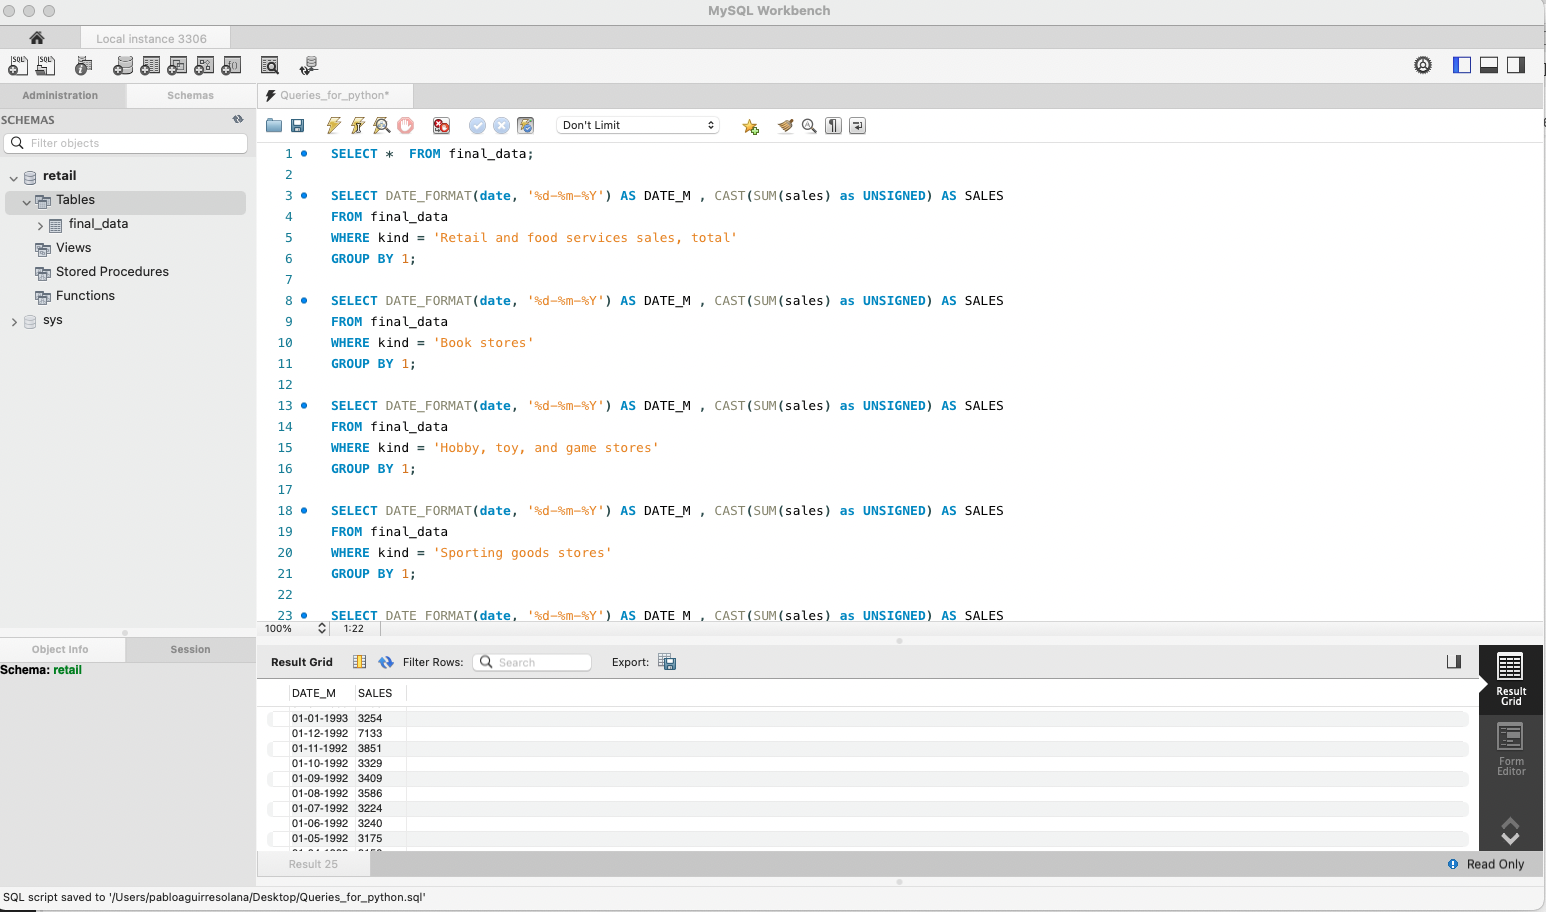

#### Observations:

- Once we checked that the queries were running we wrote the following `Installation Script` to run this same queries through python, and therefore have a more simplified data set to do `Time Series analysis`.
- We did a total of `five queries` (one for each category) to sum up the sales, through all the years and months.

In [12]:
#Script for querying data from MYSQL

cnx = mysql.connector.connect(user='root',
    password= 'catalina',
    host= '127.0.0.1',
    database = 'ret2', 
    auth_plugin= 'mysql_native_password')


cursor = cnx.cursor()

#Query for Total Retail
sql1 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Retail and food services sales, total'
GROUP BY 1;
       
""")

cursor.execute(sql1)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
retail_df = pd.read_sql(sql1, con=cnx)
retail_df.rename(columns = {'SALES': 'retail_s'}, inplace = True) 
print(retail_df)


#Query for Book Stores
sql2 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Book stores' 
GROUP BY 1;
       
""")

cursor.execute(sql2)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
books_df = pd.read_sql(sql2, con=cnx)
books_df.rename(columns = {'SALES': 'books_s'}, inplace = True) 
print(books_df)


#Query for 'Hobby, toy, and game stores' 

sql3 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Hobby, toy, and game stores' 
GROUP BY 1;
       
""")

cursor.execute(sql3)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
hobby_df = pd.read_sql(sql3, con=cnx)
hobby_df.rename(columns = {'SALES': 'hobby_s'}, inplace = True) 
print(hobby_df)


#Query for 'Sporting goods stores' 

sql4 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Sporting goods stores' 
GROUP BY 1;
       
""")

cursor.execute(sql4)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
sporting_df = pd.read_sql(sql4, con=cnx)
sporting_df.rename(columns = {'SALES': 'sporting_s'}, inplace = True) 
print(sporting_df)


#Query for ''Sporting goods, hobby, musical instrument, and book stores' ' 

sql5 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Sporting goods, hobby, musical instrument, and book stores' 
GROUP BY 1;
       
""")

cursor.execute(sql5)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
entretainment_df = pd.read_sql(sql5, con=cnx)
entretainment_df.rename(columns = {'SALES': 'entretain_s'}, inplace = True) 
print(entretainment_df)

#Query for ''Women''s clothing stores' ' 

sql6 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Women''s clothing stores' 
GROUP BY 1;
       
""")

cursor.execute(sql6)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
womens_df = pd.read_sql(sql6, con=cnx)
womens_df.rename(columns = {'SALES': 'womens_s'}, inplace = True) 
print(womens_df)



#Query for ''Men''s clothing stores'  ' 

sql7 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Men''s clothing stores' 
GROUP BY 1;
       
""")

cursor.execute(sql7)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
mens_df = pd.read_sql(sql7, con=cnx)
mens_df.rename(columns = {'SALES': 'mens_s'}, inplace = True) 
print(mens_df)

#Create a data frame for analysis aggregating all categories by date

time_series = pd.DataFrame()

time_series['Date'] = retail_df['DATE_M']
time_series['retail_s'] = retail_df['retail_s']  
time_series['hobby_s'] = hobby_df['hobby_s']  
time_series['books_s'] = books_df['books_s']  
time_series['sporting_s'] = sporting_df['sporting_s']  
time_series['entretain_s'] = entretainment_df['entretain_s']  
time_series['womens_s'] = womens_df['womens_s']  
time_series['mens_s'] = mens_df['mens_s']  



#Convert variable 'Date' into a timestamp
time_series['Date'] = time_series['Date'].astype('datetime64[ns]')



('01-02-2021', 490657)
('01-01-2021', 517119)
('01-12-2020', 611429)
('01-11-2020', 543273)
('01-10-2020', 553114)
('01-09-2020', 530987)
('01-08-2020', 545307)
('01-07-2020', 549416)
('01-06-2020', 532678)
('01-05-2020', 504607)
('01-04-2020', 407227)
('01-03-2020', 478267)
('01-02-2020', 478467)
('01-01-2020', 480301)
('01-12-2019', 587471)
('01-11-2019', 532130)
('01-10-2019', 522195)
('01-09-2019', 493076)
('01-08-2019', 541951)
('01-07-2019', 528710)
('01-06-2019', 515269)
('01-05-2019', 544203)
('01-04-2019', 506920)
('01-03-2019', 513845)
('01-02-2019', 442274)
('01-01-2019', 456538)
('01-12-2018', 556614)
('01-11-2018', 518457)
('01-10-2018', 503602)
('01-09-2018', 477137)
('01-08-2018', 520544)
('01-07-2018', 505209)
('01-06-2018', 507106)
('01-05-2018', 527991)
('01-04-2018', 480373)
('01-03-2018', 508383)
('01-02-2018', 435373)
('01-01-2018', 444286)
('01-12-2017', 558215)
('01-11-2017', 497748)
('01-10-2017', 476014)
('01-09-2017', 469710)
('01-08-2017', 490324)
('01-07-201

In [13]:
#Sanity Check on the final dataframe for Time Series analysis and Visualization.
time_series.head()

,Date,retail_s,hobby_s,books_s,sporting_s,entretain_s,womens_s,mens_s
0,2021-01-02,490657,1444,458,3819,6409,2069,353
1,2021-01-01,517119,1646,820,4150,7421,2043,349
2,2020-01-12,611429,2617,900,6799,11319,3399,604
3,2020-01-11,543273,2412,496,4620,8368,2726,0
4,2020-01-10,553114,1674,455,4684,7657,2634,0


In [14]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         350 non-null    datetime64[ns]
 1   retail_s     350 non-null    int64         
 2   hobby_s      350 non-null    int64         
 3   books_s      350 non-null    int64         
 4   sporting_s   350 non-null    int64         
 5   entretain_s  350 non-null    int64         
 6   womens_s     350 non-null    int64         
 7   mens_s       350 non-null    int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 22.0 KB


[Back to top](#Index)


## 5.Exploring Trends

**Definition of a trend**

- According to the IMF (Internation Monetary Fund): Various methodologies are used to estimate potential output (of the economy), but they all assume that output can be divided into a trend and a cyclical component. Te trend is interpreted as ameasure of the economy’s potential output and the cycle as a measure of the output gap

- In a broader sense; en economic trend lets us see the behavior through time of a specific of a countiry's economy, in our case retail, and thourgh it to be able to detect patterns, cycles, anomalies and generate forecasts as well.


#### Analysis of Sporting goods, hobby, musical instrument, and book stores, Sporting goods stores ,Hobby, toy, and game stores, Book stores and Retail and food services sales, total.

First we wrote a code, to graphically inspect the time series for each category along the different years compared to the Total Retail and food services total. 
This will let us have some visibility on general behavior of the series.

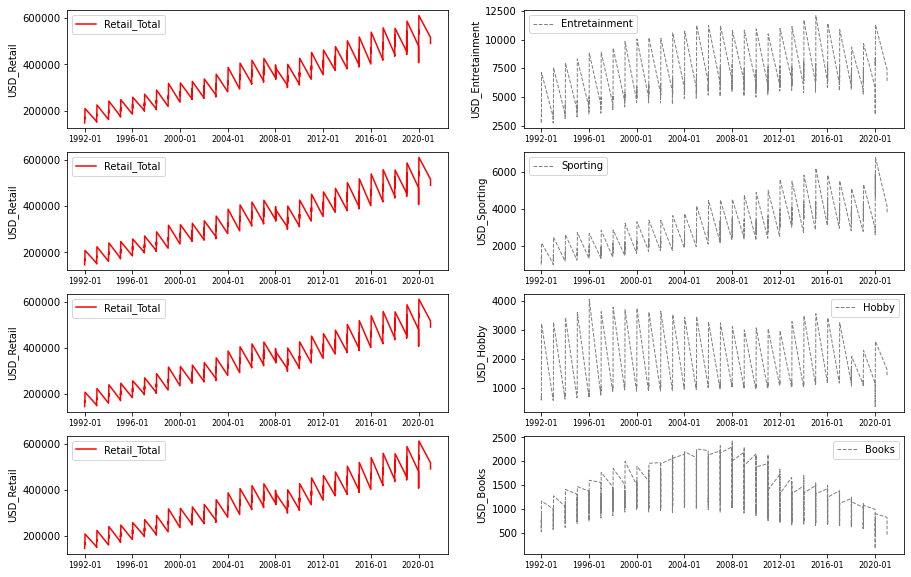

In [15]:
#Code to plot the different categories in comparison with the Total Retail and food services total. 

fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8))= plt.subplots(4, 2, figsize =(15,10))

ax1.set_ylabel('USD_Retail')
ax1.plot(time_series['Date'], time_series['retail_s'], color='red',
         label = 'Retail_Total')
ax1.legend()
ax1.tick_params(axis='y')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_tick_params(rotation=0,labelsize = 8)

 
ax2.set_ylabel('USD_Entretainment',)  # we already handled the x-label with ax1
ax2.plot(time_series['Date'], time_series['entretain_s'], ls = '--', lw = 1, color='gray',
         label = 'Entretainment')
ax2.legend()
ax2.tick_params(axis='y')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax3.set_ylabel('USD_Retail')
ax3.plot(time_series['Date'], time_series['retail_s'], color='red',
         label = 'Retail_Total')
ax3.legend()
ax3.tick_params(axis='y')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_tick_params(rotation=0,labelsize = 8)

    
ax4.set_ylabel('USD_Sporting',)  # we already handled the x-label with ax1
ax4.plot(time_series['Date'], time_series['sporting_s'], ls = '--', lw = 1, color='gray',
         label = 'Sporting')
ax4.legend()
ax4.tick_params(axis='y')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax4.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax5.set_ylabel('USD_Retail')
ax5.plot(time_series['Date'], time_series['retail_s'], color='red',
         label = 'Retail_Total')
ax5.legend()
ax5.tick_params(axis='y')
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax5.xaxis.set_tick_params(rotation=0,labelsize = 8)

    
ax6.set_ylabel('USD_Hobby',)  # we already handled the x-label with ax1
ax6.plot(time_series['Date'], time_series['hobby_s'], ls = '--', lw = 1, color='gray',
         label = 'Hobby')
ax6.legend()
ax6.tick_params(axis='y')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax6.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax7.set_ylabel('USD_Retail')
ax7.plot(time_series['Date'], time_series['retail_s'], color='red',
         label = 'Retail_Total')
ax7.legend()
ax7.tick_params(axis='y')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax7.xaxis.set_tick_params(rotation=0,labelsize = 8)

    
ax8.set_ylabel('USD_Books',)  # we already handled the x-label with ax1
ax8.plot(time_series['Date'], time_series['books_s'], ls = '--', lw = 1, color='gray',
         label = 'Books')
ax8.legend()
ax8.tick_params(axis='y')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax8.xaxis.set_tick_params(rotation=0,labelsize = 8)

plt.show()


#### Observations:

- From the charts above we can see that there are some general spending patterns within the different categories: There is a general upward trend in the Retail Total series, with very clear seasonal spikes, that might correspond to Christmas/January, Summer and Fall(Thanks Giving) Sales. 
- Worth to notice is the negative spike in all the categories in 2020 which was the year of the COVID pandemic.
- The only category that has a different trend behavior is bookstores, which started to present a downward trend since 2008.

### Time Series Decomposition

- To thoroughly asses if a time series has a trend, and a seasonal component, one must decompose the series. Which is a statistical method, to breakdown a series into systematic and unsystematic components. 


- A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.


- `Trend`: The increasing or decreasing value in the series.
- `Seasonality`: The repeating short-term cycle in the series.
- `Noise:` The random variation in the series.

The following code will provide the necessary steps to compute all this three components:

In [16]:
#First; we need to create a separate data frame for each category.

a = time_series.copy()
retail = a.drop(['hobby_s', 'books_s', 'sporting_s', 'entretain_s', 'womens_s', 'mens_s' ], axis=1)
retail = retail.set_index('Date')
entretain = a.drop(['hobby_s', 'books_s', 'sporting_s', 'retail_s', 'womens_s', 'mens_s' ], axis=1)
entretain = entretain.set_index('Date')
sporting = a.drop(['hobby_s', 'books_s', 'entretain_s','retail_s', 'womens_s', 'mens_s' ], axis=1)
sporting = sporting.set_index('Date')
hobby = a.drop(['sporting_s', 'books_s', 'entretain_s','retail_s', 'womens_s', 'mens_s' ], axis=1)
hobby = hobby.set_index('Date')
books = a.drop(['sporting_s', 'hobby_s', 'entretain_s','retail_s', 'womens_s', 'mens_s' ], axis=1)
books = books.set_index('Date')
womens = a.drop(['sporting_s', 'hobby_s', 'entretain_s','retail_s', 'books_s', 'mens_s' ], axis=1)
womens = womens.set_index('Date')
mens = a.drop(['sporting_s', 'hobby_s', 'entretain_s','retail_s', 'books_s', 'womens_s' ], axis=1)
mens = mens.set_index('Date')

#Secondly with Statsmodel Time Series Decomposition library we create a model for each category.
#If the seasonality amplitude is independent of the level(mean) of the series one should use the additive model,
#which is the one we are going to use. 

deco_ret = sm.tsa.seasonal_decompose(retail, model= 'additive', period = 12)
deco_ent = sm.tsa.seasonal_decompose(entretain, model= 'additive', period = 12)
deco_spo = sm.tsa.seasonal_decompose(sporting, model= 'additive', period = 12)
deco_hob = sm.tsa.seasonal_decompose(hobby, model= 'additive', period = 12)
deco_boo = sm.tsa.seasonal_decompose(books, model= 'additive', period = 12)
deco_wom = sm.tsa.seasonal_decompose(womens, model= 'additive', period = 12)
deco_men = sm.tsa.seasonal_decompose(mens, model= 'additive', period = 12)

#To plot the components of the decomposition model we pass the model to a dataframe format.
decomposed_data_a = pd.DataFrame()

decomposed_data_a['trend_ret'] = deco_ret.trend
decomposed_data_a['seasonal_ret'] = deco_ret.seasonal
decomposed_data_a['random_noise_ret'] = deco_ret.resid
decomposed_data_a['trend_ent'] = deco_ent.trend
decomposed_data_a['seasonal_ent'] = deco_ent.seasonal
decomposed_data_a['random_noise_ent'] = deco_ent.resid
decomposed_data_a['trend_spo'] = deco_spo.trend
decomposed_data_a['seasonal_spo'] = deco_spo.seasonal
decomposed_data_a['random_noise_spo'] = deco_spo.resid
decomposed_data_a['trend_hob'] = deco_hob.trend
decomposed_data_a['seasonal_hob'] = deco_hob.seasonal
decomposed_data_a['random_noise_hob'] = deco_hob.resid
decomposed_data_a['trend_boo'] = deco_boo.trend
decomposed_data_a['seasonal_boo'] = deco_boo.seasonal
decomposed_data_a['random_noise_boo'] = deco_boo.resid

Netx we plot each of the categories and asses if there is a clear trend, seasonality and the level of noise.

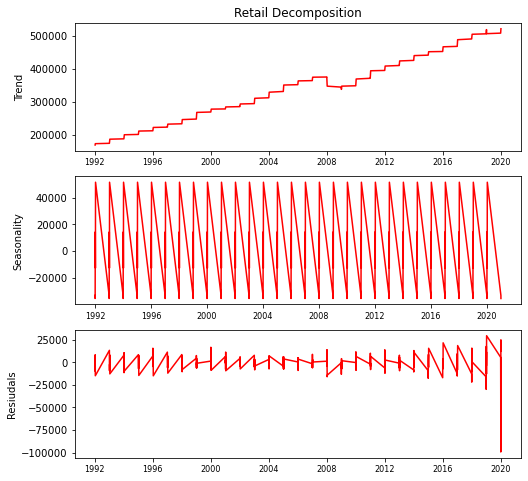

In [17]:
#Retail decomposition plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(8,8))


ax1.set_ylabel('Trend')
ax1.plot(decomposed_data_a.index, decomposed_data_a['trend_ret'], color='red')
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax1.set_title('Retail Decomposition')

ax2.set_ylabel('Seasonality')
ax2.plot(decomposed_data_a.index, decomposed_data_a['seasonal_ret'], color='red')
ax2.tick_params(axis='y')
ax2.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax3.set_ylabel('Resiudals')
ax3.plot(decomposed_data_a.index, decomposed_data_a['random_noise_ret'], color='red')
ax3.tick_params(axis='y')
ax3.xaxis.set_tick_params(rotation=0,labelsize = 8)

plt.show()

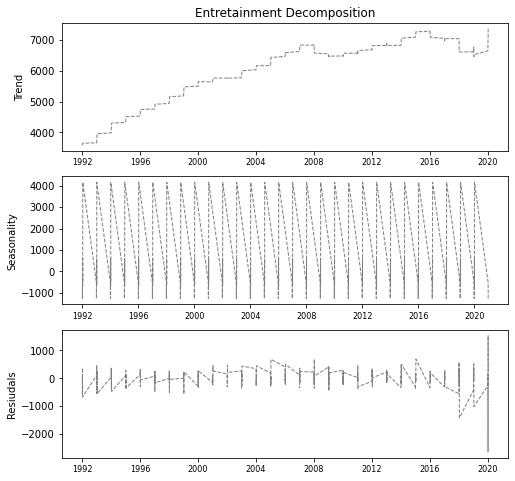

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(8,8))


ax1.set_ylabel('Trend')
ax1.plot(decomposed_data_a.index, decomposed_data_a['trend_ent'], ls = '--', lw = 1, color='gray')
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax1.set_title('Entretainment Decomposition')

ax2.set_ylabel('Seasonality')
ax2.plot(decomposed_data_a.index, decomposed_data_a['seasonal_ent'], ls = '--', lw = 1, color='gray')
ax2.tick_params(axis='y')
ax2.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax3.set_ylabel('Resiudals')
ax3.plot(decomposed_data_a.index, decomposed_data_a['random_noise_ent'], ls = '--', lw = 1, color='gray')
ax3.tick_params(axis='y')
ax3.xaxis.set_tick_params(rotation=0,labelsize = 8)

plt.show()

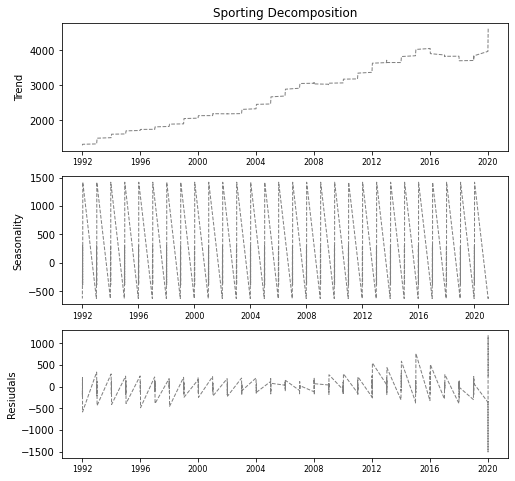

In [19]:
#Sports Decomposition plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(8,8))


ax1.set_ylabel('Trend')
ax1.plot(decomposed_data_a.index, decomposed_data_a['trend_spo'], ls = '--', lw = 1, color='gray')
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax1.set_title('Sporting Decomposition')

ax2.set_ylabel('Seasonality')
ax2.plot(decomposed_data_a.index, decomposed_data_a['seasonal_spo'], ls = '--', lw = 1, color='gray')
ax2.tick_params(axis='y')
ax2.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax3.set_ylabel('Resiudals')
ax3.plot(decomposed_data_a.index, decomposed_data_a['random_noise_spo'], ls = '--', lw = 1, color='gray')
ax3.tick_params(axis='y')
ax3.xaxis.set_tick_params(rotation=0,labelsize = 8)

plt.show()

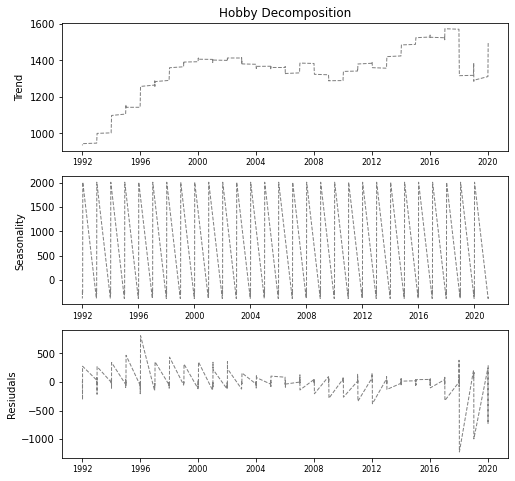

In [20]:
#Hobby Decomsposition plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(8,8))


ax1.set_ylabel('Trend')
ax1.plot(decomposed_data_a.index, decomposed_data_a['trend_hob'], ls = '--', lw = 1, color='gray')
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax1.set_title('Hobby Decomposition')

ax2.set_ylabel('Seasonality')
ax2.plot(decomposed_data_a.index, decomposed_data_a['seasonal_hob'], ls = '--', lw = 1, color='gray')
ax2.tick_params(axis='y')
ax2.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax3.set_ylabel('Resiudals')
ax3.plot(decomposed_data_a.index, decomposed_data_a['random_noise_hob'], ls = '--', lw = 1, color='gray')
ax3.tick_params(axis='y')
ax3.xaxis.set_tick_params(rotation=0,labelsize = 8)

plt.show()

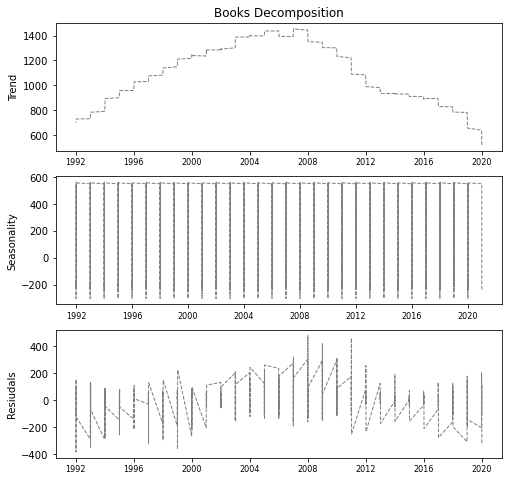

In [21]:
#Books Decomsposition plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(8,8))


ax1.set_ylabel('Trend')
ax1.plot(decomposed_data_a.index, decomposed_data_a['trend_boo'], ls = '--', lw = 1, color='gray')
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax1.set_title('Books Decomposition')

ax2.set_ylabel('Seasonality')
ax2.plot(decomposed_data_a.index, decomposed_data_a['seasonal_boo'], ls = '--', lw = 1, color='gray')
ax2.tick_params(axis='y')
ax2.xaxis.set_tick_params(rotation=0,labelsize = 8)


ax3.set_ylabel('Resiudals')
ax3.plot(decomposed_data_a.index, decomposed_data_a['random_noise_boo'], ls = '--', lw = 1, color='gray')
ax3.tick_params(axis='y')
ax3.xaxis.set_tick_params(rotation=0,labelsize = 8)

plt.show()

#### Observations:

- From the charts above we can see that there is a clear upward trend, a clear sesonal effect with sales going up in certain periods and sales going down in others, and finally some randommess (noise) at the year 2020 for the Total Retail Series, Entretainment category, Sportings cetgory and Hobby. This last one with more noise and downard trend through the years 2019-2021.

- The Books category is the one which represents an un clear trend and more noise.

- From the above charts it is very clear that there were major changes in all categories due to the pandemic which started in Februrary 2020.

[Back to top](#Index)


## 6.Exploring Percent Change

`Percent Change` is a formula to calculate the precentage between one quantity over another, througout a specific period in time. In economics and finance for example; percentage change is used to track the changes in revenues, trends, income etc.. and thus have a metric that can quantify the impact of drastic changes (positively and negatively).

### Women's and men's clothing business case.

In the below section we will explore briefly how does this two business have changed over time and how this is reflected on its percent change.

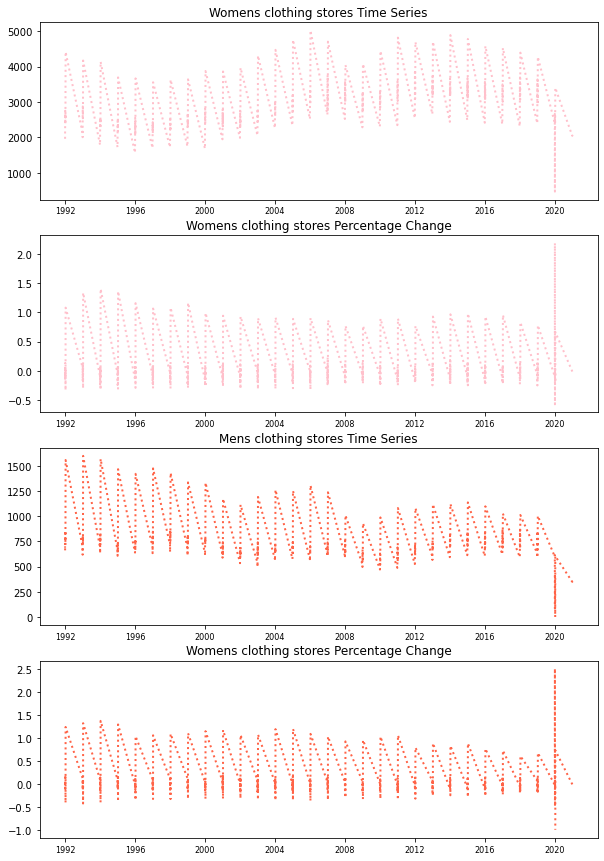

In [22]:
#Use the data frames created previously and add a column for the percentage change
womens['pct_chg'] = womens.pct_change()
mens['pct_chg'] = mens.pct_change()


#Create the plots to visualize the series and the percent changes
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, figsize=(10, 15))

ax1.plot(womens.index, womens['womens_s'], color ='pink', ls = 'dotted', lw = 2)
ax1.tick_params(axis='y')
ax1.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax1.set_title('Womens clothing stores Time Series')

ax2.plot(womens.index, womens['pct_chg'], color = 'pink', ls= 'dotted', lw = 2)
ax2.tick_params(axis='y')
ax2.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax2.set_title('Womens clothing stores Percentage Change')

ax3.plot(mens.index, mens['mens_s'], color ='tomato', ls = 'dotted', lw = 2)
ax3.tick_params(axis='y')
ax3.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax3.set_title('Mens clothing stores Time Series')

ax4.plot(mens.index, mens['pct_chg'], color = 'tomato', ls= 'dotted', lw = 2)
ax4.tick_params(axis='y')
ax4.xaxis.set_tick_params(rotation=0,labelsize = 8)
ax4.set_title('Womens clothing stores Percentage Change')

plt.show()

#### Observations:

- From the charts above we can see that there is some upward pattern in women's clothing stores and a big downward spike at 2020, which as we have seen before in the other categories, can be the effect of the COVID Pandemic. 

- For men's clothing the story is different, because visually we can notice that there is a systematic decay in the series and a big drift with the Pandemic.

- Both charts of percent change, tell us the range of the variantion between the sales of one year to other, and on average the variation for both categories are between -.05% and 1%. With the pandemic this percentage changes abruptly to almost -1% to 2%.

### Relationship among business

In the below section we will explore briefly how does this two business are related and what is the percentage contribution to the whole and how does it changes over time.

To asses the relationship amomng the two businesses we can perform a simple linear regression model to see how the two business are related and to also asses how do they contribute to whole.

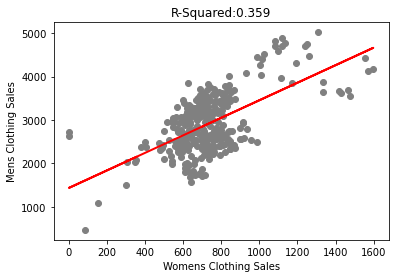

In [23]:
#Transform variables into arrays 
Retail = retail.retail_s.values.reshape(len(retail['retail_s']), 1)
Womens = womens.womens_s.values.reshape(len(womens['womens_s']), 1)
Mens = mens.mens_s.values.reshape(len(mens['mens_s']), 1)


#Fit a simple linear model with Womens and Mens series 
womens_model = linear_model.LinearRegression()
womens_model.fit(Mens, Womens)

coeffs_womens = np.array(list(womens_model.intercept_.flatten()) + 
                         list(womens_model.coef_.flatten()))

womens_rsq = round(womens_model.score(Mens, Womens),3) 

#Plot the simple linear model 
plt.scatter(Mens, Womens,  color='gray')
plt.xlabel('Womens Clothing Sales')
plt.ylabel('Mens Clothing Sales')
plt.plot(Mens, womens_model.predict(Mens), color='red', linewidth=2)
plt.title('R-Squared:' + str(womens_rsq))
plt.show()

- As the results of the simple model suggest, there is not much contribution on the Womens Sales to Men Sales, what the R-squared is telling us is that only .35% of the Variance in Womens Clothing Sales is explained by Men Sales. 
- It is in this regard that we can conclude that this two variables might be affected by other factors, rather than by each other.

[Back to top](#Index)


## 7.Exploring Rolling Time Windows

-In econmics and many other domains, a `Window Rolling` is a calculation, typically the average on a specific frame of time. The moving average creates an updated average value fo each row based on the window you specify (periods). This is very important to smooth the series (take off the noise) and thus make predictions and forecasts, otherwise, the forecast and predictions, would suffer from the noise and variations inherent to the series.

- For this section I chose Food services and drinking places and Full services restaurants.

In [24]:
#Connect to sql
cnx = mysql.connector.connect(user='root',
    password= 'catalina',
    host= '127.0.0.1',
    database = 'ret2', 
    auth_plugin= 'mysql_native_password')


cursor = cnx.cursor()



#Query for Food Serivices and drinking places
sql8 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Food services and drinking places' 
GROUP BY 1;

       
""")

cursor.execute(sql8)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
food_df = pd.read_sql(sql8, con=cnx)
food_df.rename(columns = {'SALES': 'food_s'}, inplace = True) 
print(food_df)



#Query for Full service restaurants
sql9 = ("""

SELECT DATE_FORMAT(date, '%d-%m-%Y') AS DATE_M , CAST(SUM(sales) as UNSIGNED) AS SALES
FROM final_data
WHERE kind = 'Full service restaurants' 
GROUP BY 1;

       
""")

cursor.execute(sql9)

#print all the rows
for row in cursor.fetchall():
    print(row)


#create a data frame
restaurants_df = pd.read_sql(sql9, con=cnx)
restaurants_df.rename(columns = {'SALES': 'restaurants_s'}, inplace = True) 
print(restaurants_df)


#add variable to dataframe 
time_series['food_s'] = food_df['food_s']  
time_series['restaurants_s'] = restaurants_df['restaurants_s']  


('01-02-2021', 50475)
('01-01-2021', 52757)
('01-12-2020', 51497)
('01-11-2020', 50911)
('01-10-2020', 57392)
('01-09-2020', 54740)
('01-08-2020', 56358)
('01-07-2020', 54511)
('01-06-2020', 51473)
('01-05-2020', 42321)
('01-04-2020', 30017)
('01-03-2020', 47740)
('01-02-2020', 62956)
('01-01-2020', 61567)
('01-12-2019', 66004)
('01-11-2019', 63127)
('01-10-2019', 65759)
('01-09-2019', 63520)
('01-08-2019', 68469)
('01-07-2019', 66613)
('01-06-2019', 66674)
('01-05-2019', 68306)
('01-04-2019', 63999)
('01-03-2019', 66690)
('01-02-2019', 57307)
('01-01-2019', 57077)
('01-12-2018', 63088)
('01-11-2018', 59138)
('01-10-2018', 61724)
('01-09-2018', 59965)
('01-08-2018', 64514)
('01-07-2018', 63442)
('01-06-2018', 63529)
('01-05-2018', 63941)
('01-04-2018', 60128)
('01-03-2018', 63389)
('01-02-2018', 54702)
('01-01-2018', 54478)
('01-12-2017', 61188)
('01-11-2017', 55671)
('01-10-2017', 58184)
('01-09-2017', 57132)
('01-08-2017', 58502)
('01-07-2017', 58474)
('01-06-2017', 58695)
('01-05-20

In [25]:
#Sanity check on Time Series data frame

time_series.head()

,Date,retail_s,hobby_s,books_s,sporting_s,entretain_s,womens_s,mens_s,food_s,restaurants_s
0,2021-01-02,490657,1444,458,3819,6409,2069,353,50475,0
1,2021-01-01,517119,1646,820,4150,7421,2043,349,52757,0
2,2020-01-12,611429,2617,900,6799,11319,3399,604,51497,0
3,2020-01-11,543273,2412,496,4620,8368,2726,0,50911,0
4,2020-01-10,553114,1674,455,4684,7657,2634,0,57392,0


<function matplotlib.pyplot.show(close=None, block=None)>

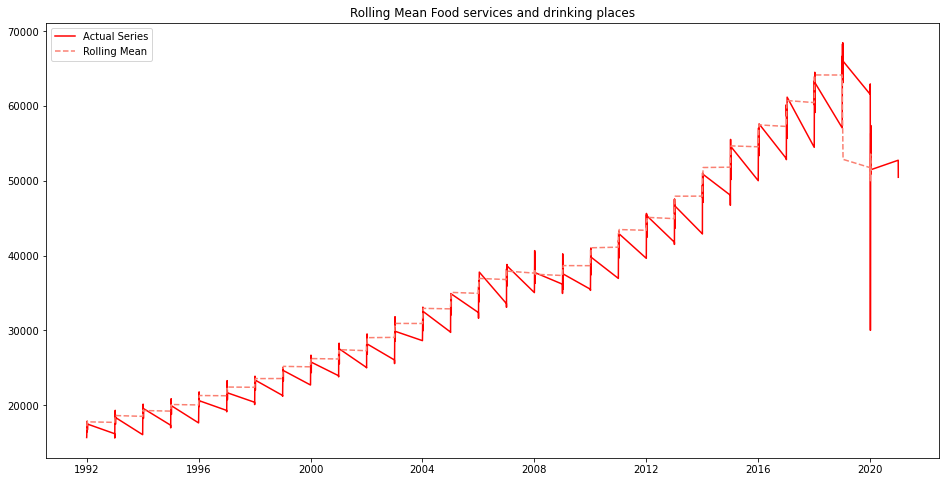

In [27]:
#Creta a data frame to visualize and calculate rolling windows for food category.
food = time_series[['Date', 'food_s']]
rolmean = food.rolling(window=14, min_periods = 3).mean()


plt.figure(figsize=(16,8))
plt.plot(food.Date, food.food_s, color = 'red', label='Actual Series')
plt.plot(food.Date, rolmean, color = 'salmon', ls ='--', label = 'Rolling Mean')
plt.title('Rolling Mean Food services and drinking places')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

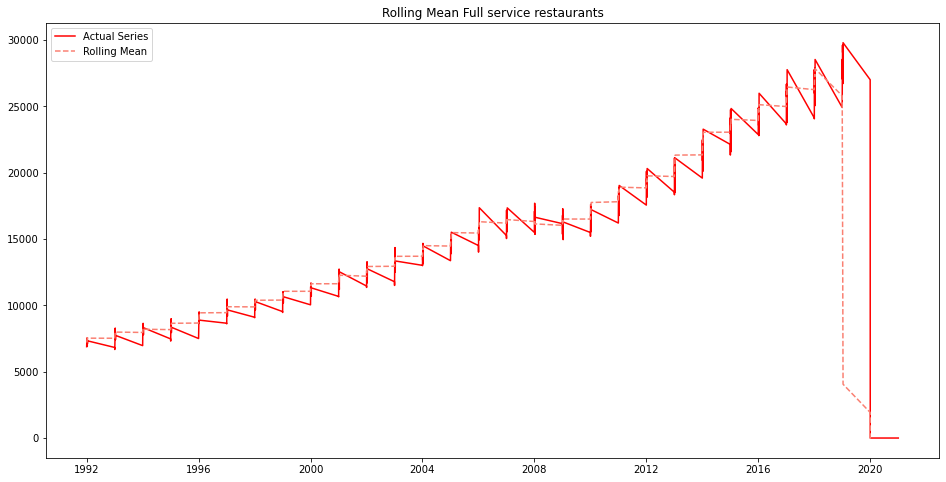

In [28]:
#Creta a data frame to visualize and calculate rolling windows for full service restaurants
rest = time_series[['Date', 'restaurants_s']]
rolmeanrest = rest.rolling(window=14, min_periods = 3).mean()


plt.figure(figsize=(16,8))
plt.plot(rest.Date, rest.restaurants_s, color = 'red', label='Actual Series')
plt.plot(rest.Date, rolmeanrest, color = 'salmon', ls ='--', label = 'Rolling Mean')
plt.title('Rolling Mean Full service restaurants')
plt.legend()
plt.show

[Back to top](#Index)


## Conclusion

- With the above analysis we can asses, with the evidence at hand that the business that seems to attract more spending are: Sporting goods and Womens Clothing. Compared to other categories, the fall the presented with the COVID pandemic is not so steep as others and they both have a general upward trend. 

- The business that seems to attract the less spending are Bookstores and Restaurants. Bookstores because presents a downward trend since 2018, and Restaurants because they were severly decimated by the Pandemic so it looks that the recovery for this sector will be slow and not very evident according to this data. 

[Back to top](#Index)


## References


Robert Yaffee, "Introduction to Time Series Analysis" 2000, Academic Press.


https://www.imf.org/external/pubs/ft/fandd/basics/pdf/Economic-concepts-explained.pdf


https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


https://medium.com/swlh/time-series-seasonal-decomposition-a300fe0f34dd


https://www.investopedia.com/terms/p/percentage-change.asp#:~:text=Percentage%20change%20is%20used%20for,an%20increase%20or%20a%20decrease.

